# Chaos (2024) Figure 4 : Redefining graph distance

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

---------------------

This notebook reproduces the results presented in _**Figure 4**_ of G. Zamora-López and M. Gilson "*[An integrative dynamical perspective for graph theory and the analysis of complex networks](https://doi.org/10.1063/5.0202241)*" Chaos 34, 041501 (2024).

---------------------

### Outline


1. Create three graphs of different classes (random, scale-free and ring-lattice).
2. Compute the graph-distance matrices $D_{ij}^g$ (geodesic distance).
3. Compute the dynamic-distance matrices $D_{ij}^{ttp}$ (time-to-peak) and compare.

---------------------

## Import libraries

In [1]:
# Library GAlib is used for generating the graphs
try:
    import galib
except ImportError:
    %pip install git+https://github.com/gorkazl/pyGAlib.git@master    

In [2]:
# Python standard library imports
from timeit import default_timer as timer

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg

import galib
from galib.metrics_numba import FloydWarshall_Numba
import sireneta as sna


In [3]:
# Enter some plotting options to control visualization
%matplotlib inline
# Define the default scale for the plots
plt.rcParams['figure.dpi'] = 72

<br>

## 1. Generate the test graphs

- Random graph of class $G(N,L)$ with uniform link probability.
- Random graph with scale-free-like degree distribution. 
- 1-dimensional ring lattice.

**NOTE**: For the small sizes here employed (*N = 100* nodes) the resulting degree distribution will be skewed but not fully scale-free.

In [4]:
# Define size and density of the networks
N = 100 
dens = 0.1 
L = int(round( 0.5 * dens * N*(N-1) ))

# Generate the three networks
rnet = galib.models.RandomGraph(N, L)
snet = galib.models.ScaleFreeGraph(N, L, exponent=2.5)
lnet = galib.models.Lattice1D_FixLinks(N,L)


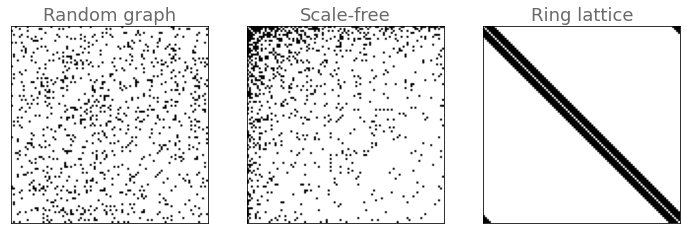

In [5]:
# Visualise the generated adjacency matrices
netlist = [rnet, snet, lnet]
titles = ['Random graph', 'Scale-free', 'Ring lattice']

plt.figure(figsize=(12,4.8))

for i, adjmat in enumerate(netlist):
    plt.subplot(1,3,i+1)
    plt.title( titles[i], fontsize=18, color='dimgray')
    plt.imshow(adjmat, cmap='gray_r')
    plt.xticks([]);
    plt.yticks([]);


<br>

## 2. Compute the graph distance matrices

In classical graph theory the (geodesic) distance between two nodes is calculated as the minimum number of links that an agent would need to traverse, in order to travel from node *i* to node *j*. The distance matrix $D_{ij}^g$ thus encodes the graph distance for all pairs of nodes. 

In [6]:
# Calculate graph distances using the FloydWarshall algorithm
dij_r = FloydWarshall_Numba(rnet)
dij_s = FloydWarshall_Numba(snet)
dij_l = FloydWarshall_Numba(lnet)

# Make sure the networks are connected, otherwise stop
diam_r = dij_r.max(); diam_s = dij_s.max(); diam_l = dij_l.max()
print( 'Diameters:', diam_r, diam_s, diam_l )
if inf in [diam_r, diam_s, diam_l]:
    raise ValueError( "At least one disconnected network" )


Diameters: 4.0 4.0 11.0


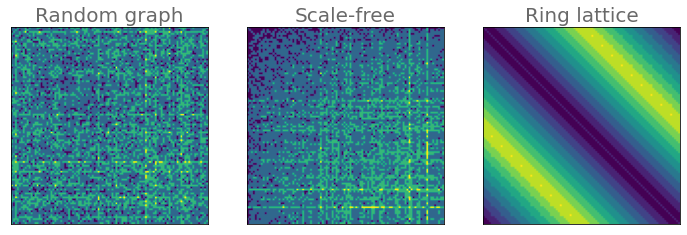

In [7]:
# Visualise the graph distance matrices
netlist = [dij_r, dij_s, dij_l]
titles = ['Random graph', 'Scale-free', 'Ring lattice']

plt.figure(figsize=(12,4.8))

for i, dijmat in enumerate(netlist):
    plt.subplot(1,3,i+1)
    plt.title( titles[i], fontsize=20, color='dimgray')
    plt.imshow(dijmat, vmin=1)
    plt.xticks([]);
    plt.yticks([]);


<br>

## 3. Compute the dynamic distance

When the links of a network are weighted, the number of "hops" given by a discrete agent when navigating the graph can no longer account for the weighted information. In *Stimulus-Response Network Analysis* the notion of distance in a graph as discrete "hops" is replaced by the notion of time that an stimulus on a node *j* needs to take effect on node *i*. This might be quantified in several manners. For the leaky-cascade model, the pair-wise responses undergo a transient peak and thus, the distance from *j* to *i* can bee evaluated as the time $t^*$ that the response $\mathcal{R}_{ij}(t)$ takes to reach its peak. To compute this *time-to-peak* distance $D_{ij}^{ttp}$ we need to:

1. Compute the temporal evolution of the response matrices $\mathcal{R}(t)$.
2. Identify the times $t^*$ at which every pair-wise response $\mathcal{R}_{ij}(t^*)$ reaches peak value.



### Calculate the temporal response matrices $\mathcal{R}(t)$ for the leaky-cascade model

In [8]:
# Compute the eigenvalues of the three networks
evs_r = numpy.linalg.eigvals(rnet)
evs_s = numpy.linalg.eigvals(snet)
evs_l = numpy.linalg.eigvals(lnet)

# Find the largest eigenvalues, and the critical τ for each network
evmax_r = evs_r.real.max(); taumax_r = 1.0 / evmax_r
evmax_s = evs_s.real.max(); taumax_s = 1.0 / evmax_s
evmax_l = evs_l.real.max(); taumax_l = 1.0 / evmax_l

# Print some feedback: spectral radius and corresponding critical 'tau's
print( '\t\tSpectral radius\t\tLargest tau' )
print( 'Random     :\t %3.5f\t\t%2.5f'  %(evmax_r, taumax_r) )
print( 'Scale-free :\t %3.5f\t\t%2.5f'  %(evmax_s, taumax_s) )
print( 'Ring latt. :\t %3.5f\t\t%2.5f'  %(evmax_l, taumax_l) )


		Spectral radius		Largest tau
Random     :	 11.30582		0.08845
Scale-free :	 15.54505		0.06433
Ring latt. :	 9.95968		0.10040


In [9]:
# Define the simulation parameters
# Set the temporal resolution
tfinal = 1
dt = 0.001
tpoints = arange(0.0, tfinal+0.1*dt, dt)
nsteps = len(tpoints)

# Set the leakage time-constants τ, proportional to taumax
tauratio = 0.4
tau_r = tauratio * taumax_r
tau_s = tauratio * taumax_s
tau_l = tauratio * taumax_l

# Define the stimulation amplitude to every node
stim = 1.0


In [10]:
# Calculate temporal evolution of the pair-wise responses R(t)
print('\nCalculating ... pair-wise response tensors, from t=0 to t=%3.1f, with step=%3.3f ...' %(tfinal, dt) )
time1 = timer()
R_r = sna.Resp_LC(rnet.T, tau=tau_r, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
R_s = sna.Resp_LC(snet.T, tau=tau_s, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
R_l = sna.Resp_LC(lnet.T, tau=tau_l, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
time2 = timer()
print( time2 - time1, 'seconds' )



Calculating ... pair-wise response tensors, from t=0 to t=1.0, with step=0.001 ...
4.2021829440000005 seconds


### Find the time-to-peak distances $D_{ij}^{ttp}$


In [11]:
# Compute the time-to-peak matrices
ttp_r = sna.Time2Peak(R_r, dt)
ttp_s = sna.Time2Peak(R_s, dt)
ttp_l = sna.Time2Peak(R_l, dt)


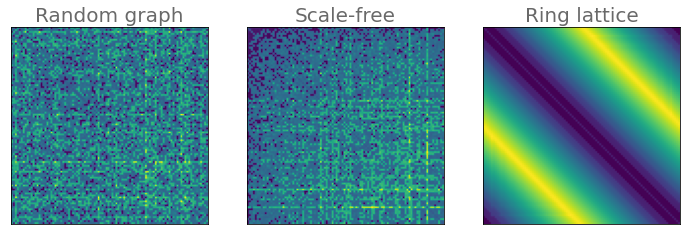

In [12]:
# Visualise the time-to-peak matrices
netlist = [ttp_r, ttp_s, ttp_l]
titles = ['Random graph', 'Scale-free', 'Ring lattice']

plt.figure(figsize=(12,4.8))

for i, ttpmat in enumerate(netlist):
    plt.subplot(1,3,i+1)
    plt.title( titles[i], fontsize=20, color='dimgray')
    plt.imshow(ttpmat)
    plt.xticks([]);
    plt.yticks([]);


### Compare geodesic and time-to-peak distances

In [13]:
# triuidx = triu_indices(N,k=0)

dijlist = [dij_r, dij_s, dij_l]
ttplist = [ttp_r, ttp_s, ttp_l]
titles = ['Random graph', 'Scale-free', 'Ring lattice']

plt.figure(figsize=(12,3.8))

for i in range(3):
    dijmat = dijlist[i]
    ttpmat = ttplist[i]
    dijpoints = dijmat[triuidx]
    ttppoints = ttpmat[triuidx]

    ax = plt.subplot(1,3,i+1)
    ax.spines[['top', 'right']].set_visible(False)
    plt.title( titles[i], fontsize=20, color='dimgray')
    
    #plt.scatter(dijpoints, ttppoints, marker='o', s=300, linewidths=0)
    plt.scatter(dijpoints, ttppoints)
    plt.tick_params(labelsize=14)
    
    plt.xlabel( 'Graph distance', fontsize=18, color='green' )
    if i==0:
        plt.ylabel( 'Time-to-peak', fontsize=18, color='indianred' )

    
plt.tight_layout()



NameError: name 'triuidx' is not defined

<Figure size 864x273.6 with 0 Axes>